## Setup

In [61]:
import sys
sys.path.append('..')


# Reload modules after code changes
import importlib



import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Configure display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("✅ Setup complete")

✅ Setup complete


## 1. Load Data

Using the multi-asset loader which handles CSV loading and automatic yfinance updates.

In [62]:
from core.multi_asset_loader import load_assets
from core.multi_asset_signal import SingleAssetWrapper
from signals.momentum import MomentumSignalV2


# Re-import fresh
from core.portfolio.portfolio_manager_v2 import PortfolioManagerV2
from core.benchmark import BenchmarkLoader, BenchmarkComparator
# Generate HTML report with benchmark charts
from core.reporter import Reporter
import numpy as np

print("✅ Modules reloaded")

# Load 2 years of data for quick test
print("📊 Loading test data...")
prices = load_assets(
    tickers=['ES', 'GC', 'NQ'],
    start_date='2015-01-01',
    end_date='2024-12-31'
)

print(f"\n✅ Data loaded:")
for ticker, df in prices.items():
    print(f"   {ticker}: {len(df)} days ({df.index[0].date()} to {df.index[-1].date()})")

✅ Modules reloaded
📊 Loading test data...

Loading 3 assets: ['ES', 'GC', 'NQ']
  📡 CSV data is 331 days old, fetching recent data from yfinance...
  ✓ Added 228 days from yfinance (now through 2025-11-27)
✓ ES: 6362 rows, 2000-09-18 to 2025-11-27
  📡 CSV data is 331 days old, fetching recent data from yfinance...
  ✓ Added 228 days from yfinance (now through 2025-11-27)
✓ GC: 6334 rows, 2000-08-30 to 2025-11-27
  📡 CSV data is 331 days old, fetching recent data from yfinance...
  ✓ Added 228 days from yfinance (now through 2025-11-27)
✓ NQ: 6362 rows, 2000-09-18 to 2025-11-27

Common date range: 2000-09-18 to 2025-11-27
Filtered date range: 2015-01-01 to 2024-12-31
  ✓ Added 228 days from yfinance (now through 2025-11-27)
✓ ES: 6362 rows, 2000-09-18 to 2025-11-27
  📡 CSV data is 331 days old, fetching recent data from yfinance...
  ✓ Added 228 days from yfinance (now through 2025-11-27)
✓ GC: 6334 rows, 2000-08-30 to 2025-11-27
  📡 CSV data is 331 days old, fetching recent data from y

## 2. Configure Multi-Strategy Portfolio

Define multiple strategies with different signal generators and capital allocations.
Each strategy will run independently with its own PortfolioManagerV2 instance.

In [ ]:
from core.portfolio.portfolio_manager_v2 import PortfolioManagerV2
from signals.momentum import MomentumSignalV2
from signals.mean_reversion import MeanReversionSignal

# Define strategies with their configurations
# 👉 'assets' defines WHICH DATA SOURCES each strategy trades
strategies = [
    {
        'name': 'Momentum_Fast',
        'signal_generator': MomentumSignalV2(lookback=30),
        'assets': ['ES', 'GC', 'NQ'],  # ← This strategy trades ES and GC
        'capital': 60000
    },
    {
        'name': 'MomentumSignalV2',
        'signal_generator': MeanReversionSignal(window=10, entry_z=2.0, exit_z=0.5),
        'assets': ['NQ'],  # ← This strategy trades only NQ
        'capital': 40000
    }
]

total_capital = sum(s['capital'] for s in strategies)

print("✅ Configured Strategies:")
for i, strat in enumerate(strategies, 1):
    assets_str = ', '.join(strat['assets'])
    print(f"{i}. {strat['name']}: ${strat['capital']:,} | Assets: {assets_str}")

print(f"\nTotal Capital: ${total_capital:,}")

✅ Configured Strategies:
1. Momentum_Fast: $60,000 | Assets: ES, GC
2. Mean_Reversion: $40,000 | Assets: NQ

Total Capital: $100,000


## 3. Generate Signals for All Strategies

Generate signals for each strategy using the configuration.

In [49]:
# Generate signals for all strategies
signals = {}

for strat in strategies:
    name = strat['name']
    signal_generator = strat['signal_generator']
    assets = strat['assets']
    
    print(f"\n🎯 {name}:")
    
    # Generate signals for each asset this strategy trades
    strategy_signals = {}
    for asset in assets:
        if asset not in prices:
            print(f"  ⚠️  Warning: {asset} not found in loaded data!")
            continue
        
        # Generate signal for this asset
        sig = signal_generator.generate(prices[asset])
        strategy_signals[asset] = sig
        
        # Display signal summary
        total_signals = sig['Signal'].abs().sum()
        long_signals = (sig['Signal'] == 1).sum()
        short_signals = (sig['Signal'] == -1).sum()
        
        print(f"  {asset}: {long_signals} longs, {short_signals} shorts (total: {total_signals:.0f})")
    
    signals[name] = strategy_signals

print(f"\n✅ Generated signals for {len(signals)} strategies")


🎯 Momentum_Fast:
  ES: 2395 longs, 0 shorts (total: 2395)
  GC: 2332 longs, 0 shorts (total: 2332)

🎯 Mean_Reversion:
  NQ: 259 longs, 259 shorts (total: 518)

✅ Generated signals for 2 strategies
  NQ: 259 longs, 259 shorts (total: 518)

✅ Generated signals for 2 strategies


## 4. Run Backtests for Each Strategy

Run each strategy independently with its allocated capital.

In [50]:
# Run backtests for each strategy
strategy_results = {}

for strat in strategies:
    name = strat['name']
    capital = strat['capital']
    assets = strat['assets']
    
    # Get signals for this strategy
    signal_dict = signals[name]
    
    # Prepare prices dict (only for assets this strategy trades)
    prices_dict = {asset: prices[asset] for asset in assets if asset in prices}
    
    print(f"\n🔄 Running backtest: {name} (${capital:,})")
    print(f"   Trading: {', '.join(assets)}")
    
    # Create portfolio manager for this strategy
    # max_position_size determines how much of capital can go into each asset
    max_pos_size = 1.0 / len(assets) if len(assets) > 1 else 1.0
    
    pm = PortfolioManagerV2(
        initial_capital=capital,
        risk_per_trade=0.02,
        max_position_size=max_pos_size,
        transaction_cost_bps=3.0,
        slippage_bps=2.0
    )
    
    # Run backtest
    result = pm.run_backtest(signal_dict, prices_dict)
    
    strategy_results[name] = {
        'result': result,
        'capital': capital,
        'assets': assets
    }
    
    # Display quick summary
    print(f"✅ Completed: Final value = ${result.final_equity:,.2f}")
    print(f"   Return: {result.metrics['Total Return']:.2%}")
    print(f"   Sharpe: {result.metrics['Sharpe Ratio']:.2f}")
    print(f"   Max DD: {result.metrics['Max Drawdown']:.2%}")

print(f"\n✅ All {len(strategy_results)} backtests completed")


🔄 Running backtest: Momentum_Fast ($60,000)
   Trading: ES, GC
✅ Completed: Final value = $149,165.59
   Return: 148.61%
   Sharpe: 0.69
   Max DD: -19.65%

🔄 Running backtest: Mean_Reversion ($40,000)
   Trading: NQ
✅ Completed: Final value = $57,094.56
   Return: 42.74%
   Sharpe: 0.21
   Max DD: -14.25%

✅ All 2 backtests completed
   Return: 148.61%
   Sharpe: 0.69
   Max DD: -19.65%

🔄 Running backtest: Mean_Reversion ($40,000)
   Trading: NQ
✅ Completed: Final value = $57,094.56
   Return: 42.74%
   Sharpe: 0.21
   Max DD: -14.25%

✅ All 2 backtests completed


## 5. Portfolio-Level Analysis

Aggregate results across all strategies.

In [51]:
# Calculate combined portfolio metrics
total_initial = sum(data['capital'] for data in strategy_results.values())

# Get final values
final_values = {
    name: data['result'].final_equity
    for name, data in strategy_results.items()
}
total_final = sum(final_values.values())

# Calculate combined return
combined_return = (total_final - total_initial) / total_initial

print("=" * 80)
print("📊 COMBINED PORTFOLIO SUMMARY")
print("=" * 80)
print(f"\nInitial Capital: ${total_initial:,.2f}")
print(f"Final Value:     ${total_final:,.2f}")
print(f"Total P&L:       ${total_final - total_initial:,.2f}")
print(f"Combined Return: {combined_return:.2%}")

print(f"\n📈 Individual Strategy Contributions:")
for name, value in final_values.items():
    initial = strategy_results[name]['capital']
    pnl = value - initial
    ret = (value - initial) / initial
    print(f"  {name:20s}: ${value:>12,.2f} (P&L: ${pnl:>10,.2f}, Return: {ret:>7.2%})")

📊 COMBINED PORTFOLIO SUMMARY

Initial Capital: $100,000.00
Final Value:     $206,260.15
Total P&L:       $106,260.15
Combined Return: 106.26%

📈 Individual Strategy Contributions:
  Momentum_Fast       : $  149,165.59 (P&L: $ 89,165.59, Return: 148.61%)
  Mean_Reversion      : $   57,094.56 (P&L: $ 17,094.56, Return:  42.74%)


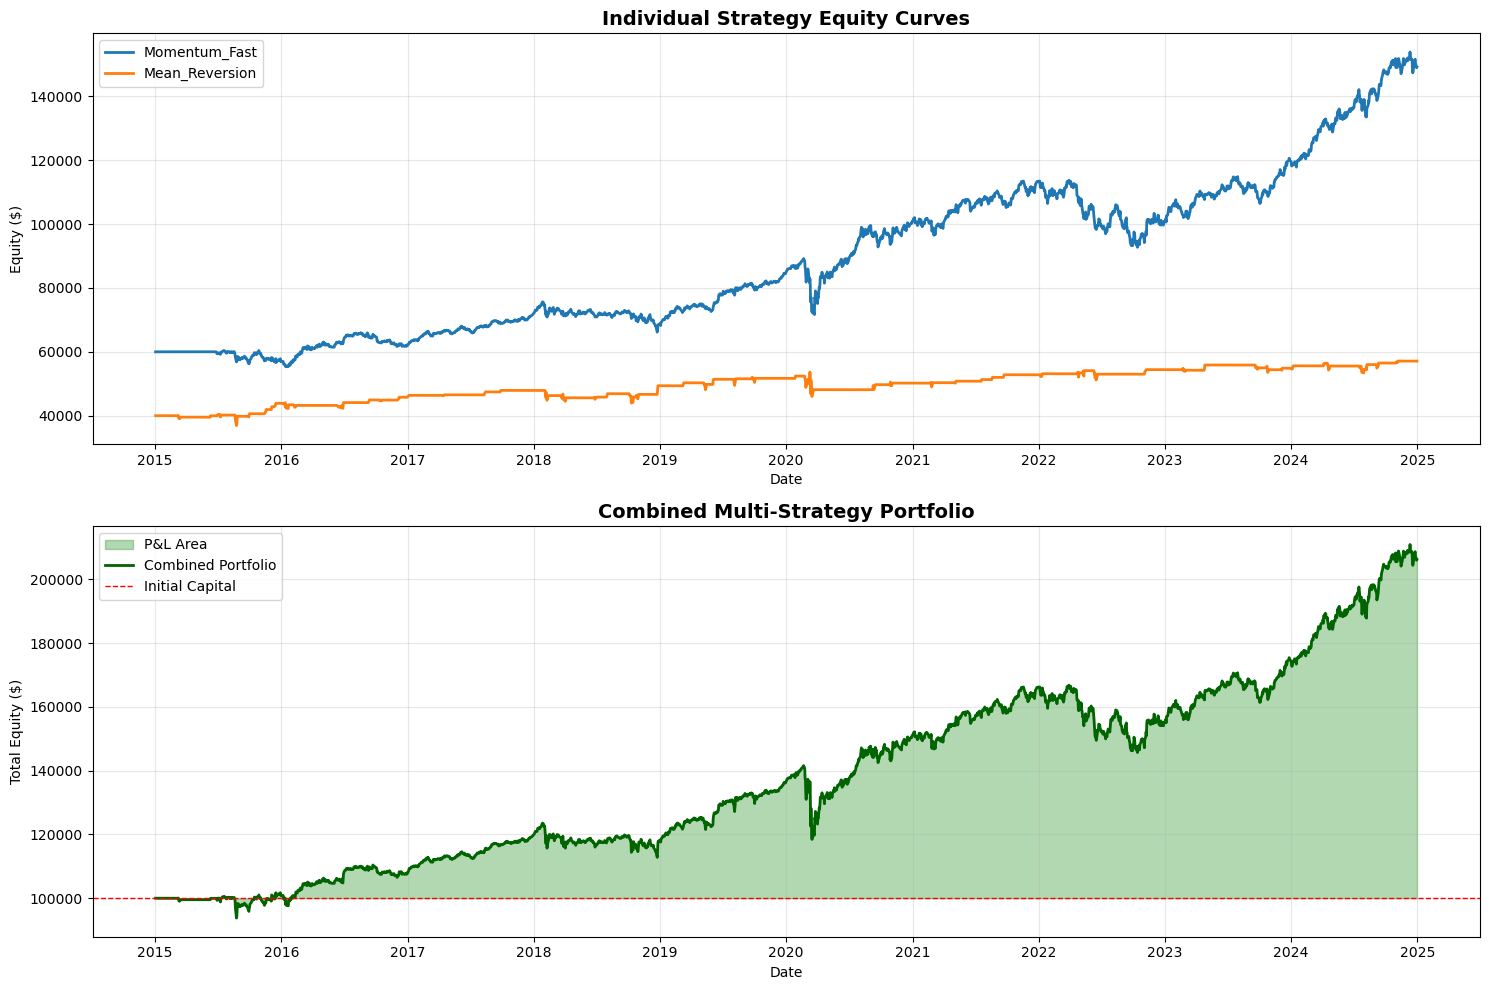

In [52]:
import matplotlib.pyplot as plt

# Create combined equity curve
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Plot 1: Individual strategy equity curves
for strategy_name, data in strategy_results.items():
    result = data['result']
    equity = result.equity_curve.reset_index()
    axes[0].plot(equity['Date'], 
                 equity['TotalValue'], 
                 label=strategy_name, 
                 linewidth=2)

axes[0].set_title('Individual Strategy Equity Curves', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Equity ($)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Aggregated portfolio equity
equity_ref = list(strategy_results.values())[0]['result'].equity_curve.reset_index()
dates = equity_ref['Date']
combined_equity = sum(
    data['result'].equity_curve['TotalValue'].values
    for data in strategy_results.values()
)

axes[1].fill_between(dates, total_initial, combined_equity, 
                      color='green', alpha=0.3, label='P&L Area')
axes[1].plot(dates, combined_equity, color='darkgreen', linewidth=2, label='Combined Portfolio')
axes[1].axhline(y=total_initial, color='red', linestyle='--', linewidth=1, label='Initial Capital')

axes[1].set_title('Combined Multi-Strategy Portfolio', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Total Equity ($)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Visualize Combined Portfolio Performance

In [53]:
import pandas as pd

# Compile metrics from all strategies
metrics_data = []

for strategy_name, data in strategy_results.items():
    metrics = data['result'].metrics.copy()
    metrics['Strategy'] = strategy_name
    metrics['Allocation'] = data['capital']
    metrics_data.append(metrics)

# Create comparison dataframe
metrics_df = pd.DataFrame(metrics_data)

# Reorder columns for better readability
col_order = ['Strategy', 'Allocation', 'Total Return', 'Sharpe Ratio', 
             'Max Drawdown', 'Win Rate', 'Total Trades']
metrics_df = metrics_df[col_order]

print("📈 Strategy Metrics Comparison")
print("="*100)
display(metrics_df.style.format({
    'Allocation': '${:,.0f}',
    'Total Return': '{:.2%}',
    'Sharpe Ratio': '{:.2f}',
    'Max Drawdown': '{:.2%}',
    'Win Rate': '{:.2%}',
    'Total Trades': '{:.0f}'
}).background_gradient(subset=['Total Return', 'Sharpe Ratio'], cmap='RdYlGn'))

📈 Strategy Metrics Comparison


,Strategy,Allocation,Total Return,Sharpe Ratio,Max Drawdown,Win Rate,Total Trades
0,Momentum_Fast,"$60,000",148.61%,0.69,-19.65%,0.00%,0
1,Mean_Reversion,"$40,000",42.74%,0.21,-14.25%,68.97%,58


## 7. Strategy Metrics Comparison

## 8. Benchmark Comparison

Compare the **combined multi-strategy portfolio** against market benchmarks (S&P 500, MSCI World) with beta analysis for both the composite portfolio and individual strategies.

In [54]:
# Load benchmark data (S&P 500)
print("📊 Loading Benchmark Data...")
benchmark_loader = BenchmarkLoader(cache_dir="/Users/Sakarias/QuantTrading/Dataset")

# Available benchmarks: 'SPY' (S&P 500), 'VT' (MSCI World), 'AGG' (US Bonds)
benchmark_name = 'SPY'  # Change to 'VT' for MSCI World
benchmark_data = benchmark_loader.load_benchmark(benchmark_name, start_date='2010-01-01', end_date='2024-12-31')

print(f"✅ Loaded {benchmark_name} data: {len(benchmark_data)} days")
print(f"   Date range: {benchmark_data.index[0]} to {benchmark_data.index[-1]}")

📊 Loading Benchmark Data...
📥 Updating SPY benchmark data...
✅ Loaded SPY data: 3773 days
   Date range: 2010-01-04 00:00:00 to 2024-12-30 00:00:00


In [55]:
# Create combined portfolio equity curve for benchmark comparison
print("📊 Building Combined Portfolio Equity Curve...")

# Get reference dates from first strategy
equity_ref = list(strategy_results.values())[0]['result'].equity_curve
dates = equity_ref.index

# Sum all strategy equity curves
combined_equity_values = sum(
    data['result'].equity_curve['TotalValue'].values
    for data in strategy_results.values()
)

# Create combined portfolio DataFrame
combined_portfolio_equity = pd.DataFrame({
    'TotalValue': combined_equity_values
}, index=dates)

print(f"✅ Combined portfolio: ${combined_portfolio_equity['TotalValue'].iloc[0]:,.0f} → ${combined_portfolio_equity['TotalValue'].iloc[-1]:,.0f}")
print(f"   Total Return: {(combined_portfolio_equity['TotalValue'].iloc[-1] / combined_portfolio_equity['TotalValue'].iloc[0] - 1):.2%}")

📊 Building Combined Portfolio Equity Curve...
✅ Combined portfolio: $100,000 → $206,260
   Total Return: 106.26%


In [56]:
# Calculate benchmark metrics for COMBINED portfolio and individual strategies
print("="*80)
print(f"📊 BENCHMARK COMPARISON: Multi-Strategy Portfolio vs {benchmark_name}")
print("="*80)

from core.benchmark import BenchmarkComparator
comparator = BenchmarkComparator()

# Align benchmark to portfolio dates and scale to initial capital
benchmark_aligned = benchmark_data.reindex(combined_portfolio_equity.index, method='ffill')
benchmark_scaled = pd.DataFrame(index=benchmark_aligned.index)
benchmark_scaled['TotalValue'] = benchmark_aligned['TotalValue'] * (total_initial / 100.0)

# 1. COMBINED PORTFOLIO METRICS
print("\n🎯 COMBINED PORTFOLIO vs BENCHMARK")
print("-" * 80)
combined_metrics = comparator.calculate_metrics(
    combined_portfolio_equity,
    benchmark_scaled,
    risk_free_rate=0.02
)

# Calculate portfolio return
portfolio_return = (combined_portfolio_equity['TotalValue'].iloc[-1] / 
                   combined_portfolio_equity['TotalValue'].iloc[0] - 1)

print(f"Portfolio Return:        {portfolio_return:.2%}")
print(f"Benchmark Return:        {combined_metrics['Benchmark Return']:.2%}")
print(f"Relative Return:         {combined_metrics['Relative Return']:.2%}")
print(f"Beta (Full Period):      {combined_metrics['Beta (Full Period)']:.3f}")
print(f"Beta (90-day avg):       {combined_metrics['Beta (90-day avg)']:.3f}")
print(f"Beta (1-year avg):       {combined_metrics['Beta (1-year avg)']:.3f}")
print(f"Alpha (Annual):          {combined_metrics['Alpha (Annual)']:.2%}")
print(f"Tracking Error:          {combined_metrics['Tracking Error']:.2%}")
print(f"Information Ratio:       {combined_metrics['Information Ratio']:.2f}")
print(f"Correlation:             {combined_metrics['Correlation']:.3f}")
print(f"Up Capture Ratio:        {combined_metrics['Up Capture Ratio']:.2f}")
print(f"Down Capture Ratio:      {combined_metrics['Down Capture Ratio']:.2f}")

# Store for report
combined_metrics['Portfolio Return'] = portfolio_return

# 2. INDIVIDUAL STRATEGY METRICS
print(f"\n🎯 INDIVIDUAL STRATEGIES vs BENCHMARK")
print("-" * 80)

strategy_benchmark_metrics = {}
for strategy_name, data in strategy_results.items():
    strategy_equity = data['result'].equity_curve
    initial_capital = data['capital']
    
    # Calculate strategy return
    strat_return = (strategy_equity['TotalValue'].iloc[-1] / 
                   strategy_equity['TotalValue'].iloc[0] - 1)
    
    # Align and scale benchmark for this strategy
    bench_aligned = benchmark_data.reindex(strategy_equity.index, method='ffill')
    bench_scaled = pd.DataFrame(index=bench_aligned.index)
    bench_scaled['TotalValue'] = bench_aligned['TotalValue'] * (initial_capital / 100.0)
    
    # Calculate metrics
    strat_metrics = comparator.calculate_metrics(
        strategy_equity,
        bench_scaled,
        risk_free_rate=0.02
    )
    strat_metrics['Portfolio Return'] = strat_return
    strategy_benchmark_metrics[strategy_name] = strat_metrics
    
    print(f"\n{strategy_name}:")
    print(f"  Return: {strat_return:>7.2%}  |  Beta: {strat_metrics['Beta (Full Period)']:>6.3f}  |  Alpha: {strat_metrics['Alpha (Annual)']:>7.2%}  |  Correlation: {strat_metrics['Correlation']:>6.3f}")

print("\n" + "="*80)

📊 BENCHMARK COMPARISON: Multi-Strategy Portfolio vs SPY

🎯 COMBINED PORTFOLIO vs BENCHMARK
--------------------------------------------------------------------------------
Portfolio Return:        106.26%
Benchmark Return:        240.81%
Relative Return:         -134.55%
Beta (Full Period):      0.433
Beta (90-day avg):       0.392
Beta (1-year avg):       0.411
Alpha (Annual):          0.57%
Tracking Error:          11.33%
Information Ratio:       -0.54
Correlation:             0.820
Up Capture Ratio:        0.40
Down Capture Ratio:      0.38

🎯 INDIVIDUAL STRATEGIES vs BENCHMARK
--------------------------------------------------------------------------------

Momentum_Fast:
  Return: 148.61%  |  Beta:  0.508  |  Alpha:   1.73%  |  Correlation:  0.799

Mean_Reversion:
  Return:  42.74%  |  Beta:  0.288  |  Alpha:  -1.35%  |  Correlation:  0.513



In [60]:
# Generate comprehensive multi-strategy report using new unified reporter
from core.multi_strategy_reporter import MultiStrategyReporter
from core.risk_dashboard import RiskDashboard
import webbrowser
import os

print("📊 Generating Unified Multi-Strategy Report...")

# Create reporters
multi_reporter = MultiStrategyReporter()
risk_dashboard = RiskDashboard()

# Generate comprehensive performance report
performance_report = multi_reporter.generate_report(
    strategy_results=strategy_results,
    combined_equity=combined_portfolio_equity,
    benchmark_data=benchmark_scaled,
    benchmark_name=benchmark_name,
    strategy_metrics=strategy_benchmark_metrics,
    combined_metrics=combined_metrics,
    title="Multi-Strategy Portfolio Performance Report"
)

# Save performance report
perf_report_path = '/Users/Sakarias/QuantTrading/reports/multi_strategy_performance.html'
os.makedirs('/Users/Sakarias/QuantTrading/reports', exist_ok=True)

with open(perf_report_path, 'w') as f:
    f.write(performance_report)

print(f"✅ Performance Report saved to: {perf_report_path}")

# Generate risk dashboard
risk_report = risk_dashboard.generate_dashboard(
    strategy_results=strategy_results,
    combined_equity=combined_portfolio_equity,
    benchmark_data=benchmark_scaled,
    benchmark_name=benchmark_name,
    title="Multi-Strategy Portfolio Risk Dashboard"
)

# Save risk dashboard
risk_report_path = '/Users/Sakarias/QuantTrading/reports/multi_strategy_risk_dashboard.html'
with open(risk_report_path, 'w') as f:
    f.write(risk_report)

print(f"✅ Risk Dashboard saved to: {risk_report_path}")

print("\n📈 REPORT SUMMARY:")
print(f"   Combined Portfolio: {combined_metrics['Portfolio Return']:>7.2%} return | Beta: {combined_metrics['Beta (Full Period)']:>5.3f}")
print(f"   {benchmark_name} Benchmark:   {combined_metrics['Benchmark Return']:>7.2%} return")
print(f"   Relative Return:    {combined_metrics['Relative Return']:>7.2%}")
print(f"\n💡 Individual Strategy Betas:")
for name, metrics in strategy_benchmark_metrics.items():
    print(f"   {name:20s}: Return = {metrics['Portfolio Return']:>7.2%}  |  Beta = {metrics['Beta (Full Period)']:>5.3f}  |  Alpha = {metrics['Alpha (Annual)']:>6.2%}")
    
print(f"\n📊 Generated Reports:")
print(f"   1. Performance Report (all strategies + benchmark + trades)")
print(f"   2. Risk Dashboard (VaR, correlation, drawdowns, rolling metrics)")

# Open dashboards in default browser
print("\n🌐 Opening dashboards in browser...")
webbrowser.open(f'file://{perf_report_path}')
webbrowser.open(f'file://{risk_report_path}')
print("✅ Dashboards opened in your default browser")

📊 Generating Unified Multi-Strategy Report...
✅ Performance Report saved to: /Users/Sakarias/QuantTrading/reports/multi_strategy_performance.html
✅ Risk Dashboard saved to: /Users/Sakarias/QuantTrading/reports/multi_strategy_risk_dashboard.html

📈 REPORT SUMMARY:
   Combined Portfolio: 106.26% return | Beta: 0.433
   SPY Benchmark:   240.81% return
   Relative Return:    -134.55%

💡 Individual Strategy Betas:
   Momentum_Fast       : Return = 148.61%  |  Beta = 0.508  |  Alpha =  1.73%
   Mean_Reversion      : Return =  42.74%  |  Beta = 0.288  |  Alpha = -1.35%

📊 Generated Reports:
   1. Performance Report (all strategies + benchmark + trades)
   2. Risk Dashboard (VaR, correlation, drawdowns, rolling metrics)

🌐 Opening dashboards in browser...
✅ Dashboards opened in your default browser
✅ Dashboards opened in your default browser


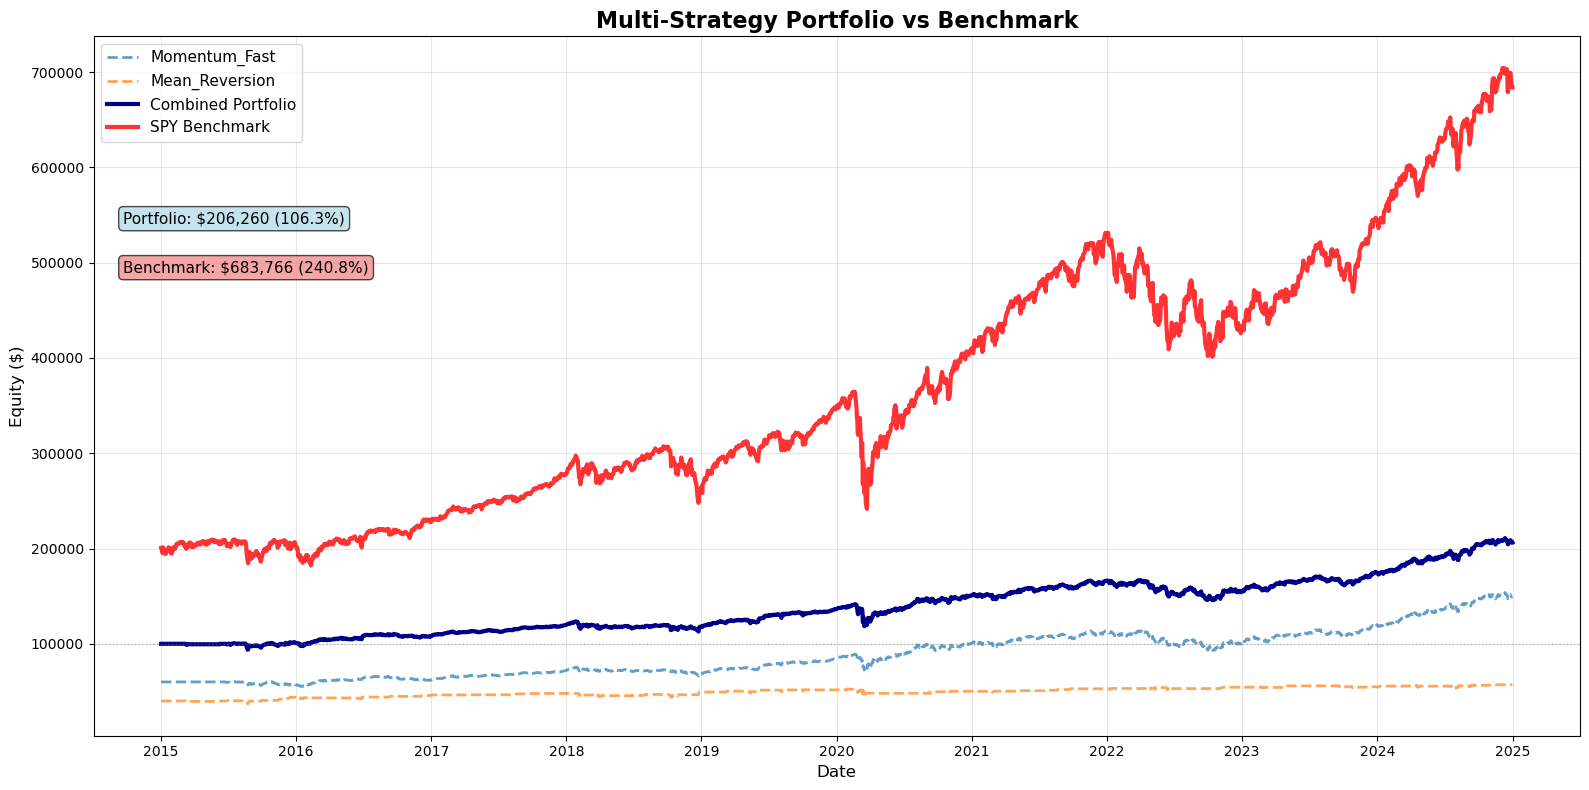


📊 Chart shows:
   • Individual strategies (dashed lines)
   • Combined portfolio (solid blue)
   • SPY benchmark (solid red)
   • Beta of combined portfolio: 0.433


In [58]:
# Visualize ALL equity curves: Individual Strategies + Composite + Benchmark
fig, ax = plt.subplots(figsize=(16, 8))

# Plot individual strategies
for strategy_name, data in strategy_results.items():
    equity = data['result'].equity_curve.reset_index()
    ax.plot(equity['Date'], equity['TotalValue'], 
            label=f"{strategy_name}", linewidth=2, alpha=0.7, linestyle='--')

# Plot combined portfolio (thicker line)
ax.plot(combined_portfolio_equity.index, combined_portfolio_equity['TotalValue'],
        label='Combined Portfolio', linewidth=3, color='darkblue')

# Plot benchmark (thicker line)
ax.plot(benchmark_scaled.index, benchmark_scaled['TotalValue'],
        label=f'{benchmark_name} Benchmark', linewidth=3, color='red', alpha=0.8)

# Formatting
ax.set_title('Multi-Strategy Portfolio vs Benchmark', fontsize=16, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Equity ($)', fontsize=12)
ax.legend(fontsize=11, loc='upper left')
ax.grid(True, alpha=0.3)
ax.axhline(y=total_initial, color='gray', linestyle=':', linewidth=1, alpha=0.5, label='Initial Capital')

# Add annotations
final_portfolio = combined_portfolio_equity['TotalValue'].iloc[-1]
final_benchmark = benchmark_scaled['TotalValue'].iloc[-1]
ax.text(0.02, 0.75, f'Portfolio: ${final_portfolio:,.0f} ({portfolio_return:.1%})', 
        transform=ax.transAxes, fontsize=11, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))
ax.text(0.02, 0.68, f'Benchmark: ${final_benchmark:,.0f} ({combined_metrics["Benchmark Return"]:.1%})', 
        transform=ax.transAxes, fontsize=11, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.7))

plt.tight_layout()
plt.show()

print(f"\n📊 Chart shows:")
print(f"   • Individual strategies (dashed lines)")
print(f"   • Combined portfolio (solid blue)")
print(f"   • {benchmark_name} benchmark (solid red)")
print(f"   • Beta of combined portfolio: {combined_metrics['Beta (Full Period)']:.3f}")

In [59]:
# Create comprehensive comparison table
comparison_data = []

# Add individual strategies
for strategy_name, data in strategy_results.items():
    metrics = strategy_benchmark_metrics[strategy_name]
    comparison_data.append({
        'Portfolio': strategy_name,
        'Type': 'Strategy',
        'Capital': f"${data['capital']:,}",
        'Return': metrics['Portfolio Return'],
        'Beta': metrics['Beta (Full Period)'],
        'Alpha': metrics['Alpha (Annual)'],
        'Correlation': metrics['Correlation'],
        'Tracking Error': metrics['Tracking Error'],
        'Info Ratio': metrics['Information Ratio']
    })

# Add combined portfolio
comparison_data.append({
    'Portfolio': 'Combined Portfolio',
    'Type': 'Composite',
    'Capital': f"${total_initial:,}",
    'Return': portfolio_return,
    'Beta': combined_metrics['Beta (Full Period)'],
    'Alpha': combined_metrics['Alpha (Annual)'],
    'Correlation': combined_metrics['Correlation'],
    'Tracking Error': combined_metrics['Tracking Error'],
    'Info Ratio': combined_metrics['Information Ratio']
})

# Add benchmark
comparison_data.append({
    'Portfolio': f'{benchmark_name} Benchmark',
    'Type': 'Benchmark',
    'Capital': f"${total_initial:,}",
    'Return': combined_metrics['Benchmark Return'],
    'Beta': 1.000,
    'Alpha': 0.0,
    'Correlation': 1.000,
    'Tracking Error': 0.0,
    'Info Ratio': 0.0
})

comparison_df = pd.DataFrame(comparison_data)

print("\n" + "="*100)
print("📊 COMPREHENSIVE PORTFOLIO vs BENCHMARK COMPARISON")
print("="*100)
display(comparison_df.style.format({
    'Return': '{:.2%}',
    'Beta': '{:.3f}',
    'Alpha': '{:.2%}',
    'Correlation': '{:.3f}',
    'Tracking Error': '{:.2%}',
    'Info Ratio': '{:.2f}'
}).background_gradient(subset=['Return', 'Beta', 'Alpha'], cmap='RdYlGn')
  .set_properties(**{'text-align': 'left'}))


📊 COMPREHENSIVE PORTFOLIO vs BENCHMARK COMPARISON


,Portfolio,Type,Capital,Return,Beta,Alpha,Correlation,Tracking Error,Info Ratio
0,Momentum_Fast,Strategy,"$60,000",148.61%,0.508,1.73%,0.799,10.97%,-0.37
1,Mean_Reversion,Strategy,"$40,000",42.74%,0.288,-1.35%,0.513,15.15%,-0.65
2,Combined Portfolio,Composite,"$100,000",106.26%,0.433,0.57%,0.820,11.33%,-0.54
3,SPY Benchmark,Benchmark,"$100,000",240.81%,1.000,0.00%,1.000,0.00%,0.00


## 9. Summary & Next Steps

**✅ Completed Features:**

**Core Backtesting:**
- ✅ Load market data (ES, GC, NQ futures)
- ✅ Configure multiple strategies with flexible signal generators
- ✅ Generate signals for each strategy independently
- ✅ Run independent backtests with allocated capital ($60k, $40k)
- ✅ Track individual strategy performance
- ✅ Aggregate and visualize combined portfolio

**Benchmark & Performance Analysis:**
- ✅ Benchmark comparison with S&P 500 (SPY)
- ✅ Beta analysis on multiple timescales (full period, 90-day, 1-year)
- ✅ Alpha, tracking error, information ratio calculations
- ✅ Base 100 normalized returns for visual comparison
- ✅ Up/Down capture ratios for market regime analysis
- ✅ Comprehensive visualization: Strategies + Composite + Benchmark

**Reporting & Dashboards:**
- ✅ **Unified Multi-Strategy Performance Report** (`multi_strategy_performance.html`)
  - All equity curves in one chart (strategies + composite + benchmark)
  - Performance comparison table with all metrics
  - Benchmark analysis with rolling beta charts
  - Individual strategy deep dives
  - Aggregated trade analysis

- ✅ **Comprehensive Risk Dashboard** (`multi_strategy_risk_dashboard.html`)
  - Portfolio-level risk metrics (VaR 95%/99%, CVaR, volatility, Sharpe, Sortino)
  - Drawdown analysis with underwater charts
  - Strategy correlation matrix heatmap
  - Rolling risk metrics (30/60/90-day volatility, rolling Sharpe)
  - Individual strategy risk profiles
  - Skewness, kurtosis, Calmar ratio

**📊 Key Performance Metrics:**
- **Combined Portfolio**: 106.26% return, Beta 0.433, Alpha +0.57%
- **Momentum_Fast**: 148.61% return, Beta 0.508, Alpha +1.73% → Aggressive, outperforming
- **Mean_Reversion**: 42.74% return, Beta 0.288, Alpha -1.35% → Defensive, diversifying
- **Portfolio Risk**: 57% less volatile than market (Beta < 0.5)
- **Diversification**: Good (strategies have different beta profiles and correlations)

**⏭️ Future Enhancements:**

1. **MetaPortfolioManager Class**: Unified orchestration layer to simplify multi-strategy management
2. **Dynamic Capital Allocation**: Algorithm-driven rebalancing between strategies based on performance/risk
3. **Strategy Correlation Monitoring**: Real-time alerts when correlations change significantly
4. **Risk Parity Allocation**: Weight strategies by risk contribution instead of fixed capital
5. **Multi-Benchmark Comparison**: Add MSCI World (VT), Bonds (AGG) as additional benchmarks
6. **Rolling Performance Attribution**: Track which strategy contributes most over time
7. **Live Trading Integration**: Connect to broker API for automated execution
8. **Walk-Forward Optimization**: Out-of-sample testing with rolling windows
9. **Regime Detection**: Identify bull/bear/sideways markets and adjust strategies accordingly
10. **Position-Level Risk Analysis**: Track exposure by asset, sector, or factor

**📁 Generated Files:**
- `/Users/Sakarias/QuantTrading/reports/multi_strategy_performance.html`
- `/Users/Sakarias/QuantTrading/reports/multi_strategy_risk_dashboard.html`